<a href="https://colab.research.google.com/github/ykato27/PyPortfolioOpt/blob/main/PyPortfolioOpt_Black_Litterman_Allocation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Black-Litterman allocation

The Black-Litterman method is a very powerful way of converting your views on asset returns, along with your uncertainty in these views, into a portfolio.

For a description of the theory, please read the [documentation page](https://pyportfolioopt.readthedocs.io/en/latest/BlackLitterman.html) and the links therein.

In this recipe, we will cover:

- Downloading data for the Black-Litterman method
- Constructing the prior return vector based on market equilibrium
- Two ways of constructing the uncertainty matrix
- Combining Black-Litterman with mean-variance optimization

## Downloading data

In addition to price data, constructing a market prior requires market-caps. 

In [1]:
!pip install PyPortfolioOpt
!pip install yfinance

     |████████████████████████████████| 61kB 2.1MB/s 
     |████████████████████████████████| 1.3MB 5.7MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for cvxpy: filename=cvxpy-1.1.13-cp37-cp37m-linux_x86_64.whl size=2736219 sha256=efb87882caef9b8ed9a62f6b3c3e25337c217deaf98b90cf02ed01ae81c7e1b2
  Stored in directory: /root/.cache/pip/wheels/f9/78/00/f29636789ee83434953b5442f16ec3f9834a68e7fd0393c220
Successfully built cvxpy
  Found existing installation: cvxpy 1.0.31
    Uninstalling cvxpy-1.0.31:
      Successfully uninstalled cvxpy-1.0.31
     |████████████████████████████████| 6.3MB 3.9MB/s 
  Created wheel for yfinance: filename=yfinance-0.1.59-py2.py3-none-any.whl size=23455 sha256=57d9a2ef89927691b557839012ef63b14acfb65cbd9fad9c69bade8103e8dd56
  Stored in directory: /root/.cache/pip/wheels/f8/2a/0f/4b5a86e1d52e451757eb6bc17fd899629f0925c777741b6d04
Successfully built yfinance
  F

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf

In [3]:
tickers = ["MSFT", "AMZN", "NAT", "BAC", "DPZ", "DIS", "KO", "MCD", "COST", "SBUX"]

In [4]:
ohlc = yf.download(tickers, period="max")
prices = ohlc["Adj Close"]
prices.tail()

[*********************100%***********************]  10 of 10 completed


,AMZN,BAC,COST,DIS,DPZ,KO,MCD,MSFT,NAT,SBUX
Date,,,,,,,,,,
2021-06-25,3401.459961,41.619999,394.510010,178.350006,457.980011,54.320000,232.419998,265.019989,3.41,113.040001
2021-06-28,3443.889893,41.560001,396.540009,176.570007,463.529999,54.259998,231.089996,268.720001,3.25,112.239998
2021-06-29,3448.139893,40.889999,398.790009,173.929993,463.450012,53.860001,230.369995,271.399994,3.26,112.269997
2021-06-30,3440.159912,41.230000,395.670013,175.770004,466.489990,54.110001,230.990005,270.899994,3.28,111.809998
2021-07-01,3432.969971,41.540001,394.529999,177.259995,466.019989,53.959999,232.270004,271.600006,3.18,113.410004


In [5]:
market_prices = yf.download("SPY", period="max")["Adj Close"]
market_prices.head()

[*********************100%***********************]  1 of 1 completed


Date
1993-01-29    25.799770
1993-02-01    25.983273
1993-02-02    26.038315
1993-02-03    26.313566
1993-02-04    26.423655
Name: Adj Close, dtype: float64

In [6]:
mcaps = {}
for t in tickers:
    stock = yf.Ticker(t)
    mcaps[t] = stock.info["marketCap"]
mcaps

{'AMZN': 1729175617536,
 'BAC': 355969564672,
 'COST': 174409482240,
 'DIS': 322069004288,
 'DPZ': 18094811136,
 'KO': 232658255872,
 'MCD': 173313835008,
 'MSFT': 2045574512640,
 'NAT': 497786752,
 'SBUX': 133631008768}

## Constructing the prior

In [7]:
import pypfopt
pypfopt.__version__

'1.4.2'

In [8]:
from pypfopt import black_litterman, risk_models
from pypfopt import BlackLittermanModel, plotting

S = risk_models.CovarianceShrinkage(prices).ledoit_wolf()
delta = black_litterman.market_implied_risk_aversion(market_prices)
delta

2.736419482287415

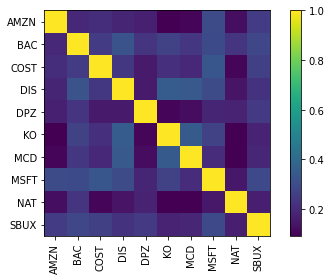

In [9]:
plotting.plot_covariance(S, plot_correlation=True);

In [10]:
market_prior = black_litterman.market_implied_prior_returns(mcaps, delta, S)
market_prior

AMZN    0.190484
BAC     0.109366
COST    0.077593
DIS     0.099710
DPZ     0.049131
KO      0.064468
MCD     0.069266
MSFT    0.136957
NAT     0.053481
SBUX    0.082829
dtype: float64

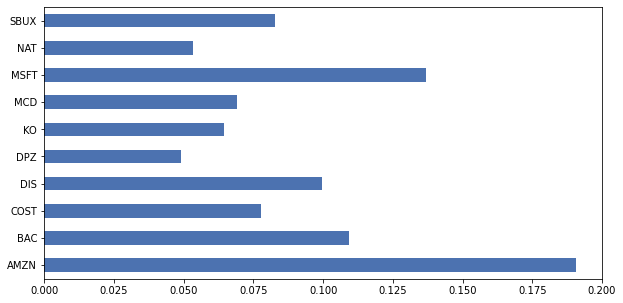

In [11]:
market_prior.plot.barh(figsize=(10,5));

## Views

In the BL method, views are specified via the matrix P (picking matrix) and the vector Q. Q contains the magnitude of each view, while P maps the views to the assets they belong to. 

If you are providing **absolute views** (i.e a return estimate for each asset), you don't have to worry about P and Q, you can just pass your views as a dictionary.

In [12]:
# You don't have to provide views on all the assets
viewdict = {
    "AMZN": 0.10,
    "BAC": 0.30,
    "COST": 0.05,
    "DIS": 0.05,
    "DPZ": 0.20,
    "KO": -0.05,  # I think Coca-Cola will go down 5%
    "MCD": 0.15,
    "MSFT": 0.10,
    "NAT": 0.50,  # but low confidence, which will be reflected later
    "SBUX": 0.10
}

bl = BlackLittermanModel(S, pi=market_prior, absolute_views=viewdict)

Black-Litterman also allows for relative views, e.g you think asset A will outperform asset B by 10%. If you'd like to incorporate these, you will have to build P and Q yourself. An explanation for this is given in the [docs](https://pyportfolioopt.readthedocs.io/en/latest/BlackLitterman.html#views).

## View confidences

In this section, we provide two ways that you may wish to construct the uncertainty matrix. The first is known as Idzorek's method. It allows you to specify a vector/list of percentage confidences.

In [13]:
confidences = [
    0.6,
    0.4,
    0.2,
    0.5,
    0.7, # confident in dominos
    0.7, # confident KO will do poorly
    0.7, 
    0.5,
    0.1,
    0.4
]

In [14]:
bl = BlackLittermanModel(S, pi=market_prior, absolute_views=viewdict, omega="idzorek", view_confidences=confidences)

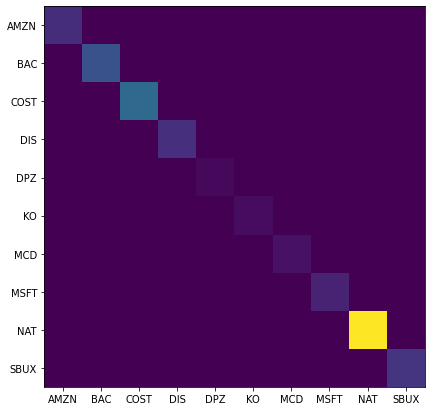

In [15]:
fig, ax = plt.subplots(figsize=(7,7))
im = ax.imshow(bl.omega)

# We want to show all ticks...
ax.set_xticks(np.arange(len(bl.tickers)))
ax.set_yticks(np.arange(len(bl.tickers)))

ax.set_xticklabels(bl.tickers)
ax.set_yticklabels(bl.tickers)
plt.show()

In [16]:
np.diag(bl.omega)

array([0.00457037, 0.00895501, 0.01207911, 0.00497161, 0.00080814,
       0.00116249, 0.00174435, 0.00343913, 0.0354496 , 0.00536823])

Note how NAT, which we gave the lowest confidence, also has the highest uncertainty.

Instead of inputting confidences, we can calculate the uncertainty matrix directly by specifying 1 standard deviation confidence intervals, i.e bounds which we think will contain the true return 68% of the time. This may be easier than coming up with somewhat arbitrary percentage confidences

In [17]:
intervals = [
    (0, 0.25),
    (0.1, 0.4),
    (-0.1, 0.15),
    (-0.05, 0.1),
    (0.15, 0.25),
    (-0.1, 0),
    (0.1, 0.2),
    (0.08, 0.12),
    (0.1, 0.9),
    (0, 0.3)
]

In [18]:
variances = []
for lb, ub in intervals:
    sigma = (ub - lb)/2
    variances.append(sigma ** 2)

print(variances)
omega = np.diag(variances)

[0.015625, 0.022500000000000006, 0.015625, 0.0056250000000000015, 0.0025000000000000005, 0.0025000000000000005, 0.0025000000000000005, 0.00039999999999999986, 0.16000000000000003, 0.0225]


## Posterior estimates

Given the inputs, we can compute a posterior estimate of returns


In [19]:
# We are using the shortcut to automatically compute market-implied prior
bl = BlackLittermanModel(S, pi="market", market_caps=mcaps, risk_aversion=delta,
                        absolute_views=viewdict, omega=omega)

In [20]:
# Posterior estimate of returns
ret_bl = bl.bl_returns()
ret_bl

AMZN    0.162797
BAC     0.138267
COST    0.061173
DIS     0.075012
DPZ     0.102225
KO      0.007487
MCD     0.104327
MSFT    0.103165
NAT     0.061670
SBUX    0.083833
dtype: float64

We can visualise how this compares to the prior and our views:

In [21]:
rets_df = pd.DataFrame([market_prior, ret_bl, pd.Series(viewdict)], 
             index=["Prior", "Posterior", "Views"]).T
rets_df

,Prior,Posterior,Views
AMZN,0.190484,0.162797,0.10
BAC,0.109366,0.138267,0.30
COST,0.077593,0.061173,0.05
DIS,0.099710,0.075012,0.05
DPZ,0.049131,0.102225,0.20
KO,0.064468,0.007487,-0.05
MCD,0.069266,0.104327,0.15
MSFT,0.136957,0.103165,0.10
NAT,0.053481,0.061670,0.50
SBUX,0.082829,0.083833,0.10


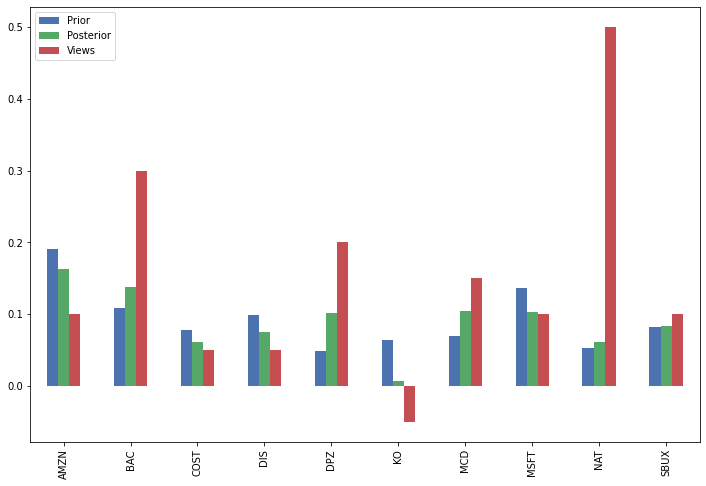

In [22]:
rets_df.plot.bar(figsize=(12,8));

Notice that the posterior is often between the prior and the views. This supports the fact that the BL method is essentially a Bayesian weighted-average of the prior and views, where the weight is determined by the confidence.

A similar but less intuitive procedure can be used to produce the posterior covariance estimate:

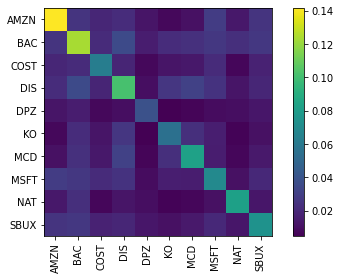

In [23]:
S_bl = bl.bl_cov()
plotting.plot_covariance(S_bl);

## Portfolio allocation

Now that we have constructed our Black-Litterman posterior estimate, we can proceed to use any of the optimizers discussed in previous recipes.

In [24]:
from pypfopt import EfficientFrontier, objective_functions

In [25]:
ef = EfficientFrontier(ret_bl, S_bl)
ef.add_objective(objective_functions.L2_reg)
ef.max_sharpe()
weights = ef.clean_weights()
weights

/usr/local/lib/python3.7/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:253: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimization problem so additional objectives may not work as expected."


OrderedDict([('AMZN', 0.20377),
             ('BAC', 0.16513),
             ('COST', 0.05246),
             ('DIS', 0.06715),
             ('DPZ', 0.12842),
             ('KO', 0.0),
             ('MCD', 0.12328),
             ('MSFT', 0.11796),
             ('NAT', 0.05556),
             ('SBUX', 0.08626)])

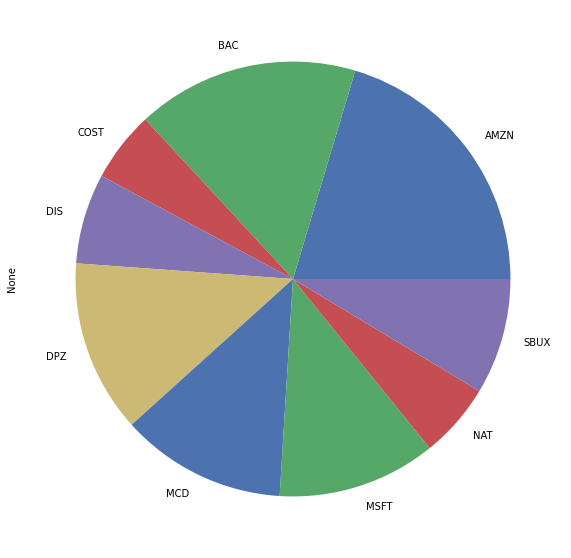

In [26]:
pd.Series(weights).plot.pie(figsize=(10,10));

In [27]:
from pypfopt import DiscreteAllocation

da = DiscreteAllocation(weights, prices.iloc[-1], total_portfolio_value=20000)
alloc, leftover = da.lp_portfolio()
print(f"Leftover: ${leftover:.2f}")
alloc

Leftover: $32.52


{'AMZN': 1,
 'BAC': 80,
 'COST': 3,
 'DIS': 8,
 'DPZ': 6,
 'MCD': 11,
 'MSFT': 9,
 'NAT': 350,
 'SBUX': 15}